# ECSE 551 MP3 G17

## Define constants, import libraries, setup device

In [30]:
# Connect to Google Drive to load the dataset
# Make sure to run this cell first!
# from google.colab import drive
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

# drive.mount('/content/drive')
# Define Global Constants
# Please modify the path according to the actual situation
TRAIN_PKL_FILE = '/home/shiyao/ECSE551-mini-project3/Train.pkl'
TRAIN_LABEL_FILE = '/home/shiyao/ECSE551-mini-project3/Train_labels.csv'
TEST_PKL_FILE = '/home/shiyao/ECSE551-mini-project3/Test.pkl'
SUBMISSION_FILE = '/home/shiyao/ECSE551-mini-project3/Submission.csv'

# Set up the device
# For Google Colab, switch the GPU runtime to gain best performance
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


## Scripts Starts Here

### Load and Read the PKL Test Dataset

<class 'numpy.ndarray'>
Data dimensions: (60000, 1, 28, 28)


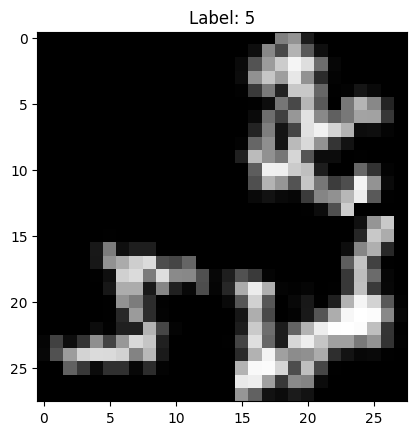

In [31]:
# File paths
pkl_file_path = TRAIN_PKL_FILE
csv_file_path = TRAIN_LABEL_FILE

# Open and load the pkl file
with open(pkl_file_path, 'rb') as file:
    data = pickle.load(file)

# Load the CSV file
labels_df = pd.read_csv(csv_file_path)

# Create a dictionary to map IDs to classes
labels_dict = dict(zip(labels_df['id'], labels_df['class']))

# Check data structure
print(type(data))  # View data type

# If the data is an image array
if isinstance(data, np.ndarray):
    print("Data dimensions:", data.shape)  # Check data dimensions

    # Assign labels from the CSV file
    image_labels = [labels_dict.get(i+1, 'Unknown') for i in range(len(data))]

    # Display the first image (assuming it is a grayscale image)
    plt.imshow(data[0].squeeze(), cmap='gray')
    plt.title(f"Label: {image_labels[0]}")
    plt.show()

## CNN

### Prepare the data

In [32]:
# 加载训练数据和标签
with open(TRAIN_PKL_FILE, 'rb') as file:
    train_data = pickle.load(file)

labels_df = pd.read_csv(TRAIN_LABEL_FILE)
labels_dict = dict(zip(labels_df['id'], labels_df['class']))
train_labels = [labels_dict.get(i + 1, 'Unknown') for i in range(len(train_data))]

# 定义自定义数据集
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

# 创建数据集和数据加载器
dataset = CustomDataset(train_data, train_labels)

### Define the CNN Model

In [5]:
# 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self, fc_units=128):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(fc_units, 10)  # 假设有 10 个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 移除了多余的 unsqueeze
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### X-Validation Training and Testing

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}")
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN().to(DEVICE)  # 将模型移动到设备上
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    for epoch in range(10):  # 根据需要调整 epoch 数量
        model.train()
        for images, labels in train_loader:
            images = images.to(DEVICE)  # 移动数据到设备上
            labels = labels.to(DEVICE)  # 移动标签到设备上
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)  # 移动数据到设备上
                labels = labels.to(DEVICE)  # 移动标签到设备上
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")

Fold 1
Epoch 1, Validation Accuracy: 79.22%
Epoch 2, Validation Accuracy: 84.55%
Epoch 3, Validation Accuracy: 85.46%
Epoch 4, Validation Accuracy: 88.17%
Epoch 5, Validation Accuracy: 89.38%
Epoch 6, Validation Accuracy: 89.52%
Epoch 7, Validation Accuracy: 89.32%
Epoch 8, Validation Accuracy: 90.80%
Epoch 9, Validation Accuracy: 90.25%
Epoch 10, Validation Accuracy: 91.03%
Fold 2
Epoch 1, Validation Accuracy: 80.72%
Epoch 2, Validation Accuracy: 84.09%
Epoch 3, Validation Accuracy: 87.43%
Epoch 4, Validation Accuracy: 88.32%
Epoch 5, Validation Accuracy: 88.78%
Epoch 6, Validation Accuracy: 90.20%
Epoch 7, Validation Accuracy: 90.06%
Epoch 8, Validation Accuracy: 90.18%
Epoch 9, Validation Accuracy: 90.39%
Epoch 10, Validation Accuracy: 90.88%
Fold 3
Epoch 1, Validation Accuracy: 84.74%
Epoch 2, Validation Accuracy: 88.77%
Epoch 3, Validation Accuracy: 89.42%
Epoch 4, Validation Accuracy: 90.36%
Epoch 5, Validation Accuracy: 91.57%
Epoch 6, Validation Accuracy: 90.99%
Epoch 7, Valida

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.nn.parallel import DataParallel
from sklearn.model_selection import KFold
import optuna

class SimpleCNN(nn.Module):
    def __init__(self, fc_units=128):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, fc_units)
        self.fc2 = nn.Linear(fc_units, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    fc_units = trial.suggest_categorical('fc_units', [64, 128, 256])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Use all available GPUs
    device_count = torch.cuda.device_count()
    print(f"Using {device_count} GPUs")
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size*device_count, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size*device_count, shuffle=False)

        # Initialize model and wrap with DataParallel
        model = SimpleCNN(fc_units=fc_units)
        model = DataParallel(model).to('cuda')
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(10):
            model.train()
            for images, labels in train_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
    
    return sum(val_accuracies) / len(val_accuracies)

# Create and optimize study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-12-05 19:26:36,150] A new study created in memory with name: no-name-f6ef63b7-532a-466b-8471-6ac14e930750


/tmp/ipykernel_1612144/3453002419.py:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Using 4 GPUs


[I 2024-12-05 19:28:10,206] Trial 0 finished with value: 81.36333333333334 and parameters: {'lr': 0.0001569301091955081, 'fc_units': 64, 'batch_size': 64}. Best is trial 0 with value: 81.36333333333334.


Using 4 GPUs


[I 2024-12-05 19:29:02,362] Trial 1 finished with value: 32.57 and parameters: {'lr': 0.005910029431733149, 'fc_units': 64, 'batch_size': 128}. Best is trial 0 with value: 81.36333333333334.


Using 4 GPUs


[I 2024-12-05 19:29:54,122] Trial 2 finished with value: 81.63166666666666 and parameters: {'lr': 0.0024982923262261256, 'fc_units': 64, 'batch_size': 128}. Best is trial 2 with value: 81.63166666666666.


Using 4 GPUs


[I 2024-12-05 19:32:39,320] Trial 3 finished with value: 46.35 and parameters: {'lr': 1.1186074075319805e-05, 'fc_units': 128, 'batch_size': 32}. Best is trial 2 with value: 81.63166666666666.


Using 4 GPUs


[I 2024-12-05 19:35:19,141] Trial 4 finished with value: 65.14333333333333 and parameters: {'lr': 0.004253368240595595, 'fc_units': 128, 'batch_size': 32}. Best is trial 2 with value: 81.63166666666666.


Using 4 GPUs


[I 2024-12-05 19:36:11,597] Trial 5 finished with value: 89.87 and parameters: {'lr': 0.0011079848663358741, 'fc_units': 256, 'batch_size': 128}. Best is trial 5 with value: 89.87.


Using 4 GPUs


[I 2024-12-05 19:37:38,267] Trial 6 finished with value: 77.15833333333333 and parameters: {'lr': 7.897669491758342e-05, 'fc_units': 128, 'batch_size': 64}. Best is trial 5 with value: 89.87.


Using 4 GPUs


[I 2024-12-05 19:39:01,740] Trial 7 finished with value: 88.72 and parameters: {'lr': 0.0003493241765867984, 'fc_units': 256, 'batch_size': 64}. Best is trial 5 with value: 89.87.


Using 4 GPUs


[I 2024-12-05 19:40:32,330] Trial 8 finished with value: 73.37666666666667 and parameters: {'lr': 4.5090078489791086e-05, 'fc_units': 256, 'batch_size': 64}. Best is trial 5 with value: 89.87.


Using 4 GPUs


[I 2024-12-05 19:43:16,524] Trial 9 finished with value: 90.96166666666666 and parameters: {'lr': 0.0012935482209570999, 'fc_units': 256, 'batch_size': 32}. Best is trial 9 with value: 90.96166666666666.


Using 4 GPUs


[I 2024-12-05 19:46:00,623] Trial 10 finished with value: 91.69833333333334 and parameters: {'lr': 0.0006563768858677396, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 19:48:39,113] Trial 11 finished with value: 91.455 and parameters: {'lr': 0.0007363814746900642, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 19:51:23,714] Trial 12 finished with value: 91.03666666666666 and parameters: {'lr': 0.00044420423886887354, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 19:54:02,914] Trial 13 finished with value: 91.38499999999999 and parameters: {'lr': 0.0008426040687764063, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 19:56:46,195] Trial 14 finished with value: 87.52 and parameters: {'lr': 0.00017526783716974285, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 19:59:30,885] Trial 15 finished with value: 84.08 and parameters: {'lr': 0.0020018346731587922, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:02:12,140] Trial 16 finished with value: 11.021666666666667 and parameters: {'lr': 0.009514219724868047, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:04:54,996] Trial 17 finished with value: 91.22833333333332 and parameters: {'lr': 0.0005092312417343149, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:07:36,954] Trial 18 finished with value: 84.71000000000001 and parameters: {'lr': 0.00018219586674633197, 'fc_units': 64, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:08:31,454] Trial 19 finished with value: 56.585 and parameters: {'lr': 3.5435019132185476e-05, 'fc_units': 128, 'batch_size': 128}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:11:11,668] Trial 20 finished with value: 91.69000000000001 and parameters: {'lr': 0.0007512338964845925, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:13:51,456] Trial 21 finished with value: 91.58 and parameters: {'lr': 0.0006723965707852482, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:16:34,080] Trial 22 finished with value: 89.06333333333333 and parameters: {'lr': 0.0022404556743864496, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:19:17,238] Trial 23 finished with value: 88.53999999999999 and parameters: {'lr': 0.000243311203682933, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:22:00,188] Trial 24 finished with value: 91.65 and parameters: {'lr': 0.000552623173350062, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:24:38,674] Trial 25 finished with value: 84.63666666666667 and parameters: {'lr': 9.144399902363797e-05, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:27:22,025] Trial 26 finished with value: 90.15666666666667 and parameters: {'lr': 0.0013690137221782468, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:30:03,547] Trial 27 finished with value: 89.53 and parameters: {'lr': 0.00032552819874625513, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:31:31,991] Trial 28 finished with value: 84.79 and parameters: {'lr': 0.0030580232539433173, 'fc_units': 64, 'batch_size': 64}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:32:25,190] Trial 29 finished with value: 86.88833333333335 and parameters: {'lr': 0.0005471068806240213, 'fc_units': 128, 'batch_size': 128}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:33:52,662] Trial 30 finished with value: 83.90166666666667 and parameters: {'lr': 0.00024721429712033793, 'fc_units': 64, 'batch_size': 64}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:36:34,865] Trial 31 finished with value: 91.62999999999998 and parameters: {'lr': 0.000806816115602819, 'fc_units': 256, 'batch_size': 32}. Best is trial 10 with value: 91.69833333333334.


Using 4 GPUs


[I 2024-12-05 20:39:18,782] Trial 32 finished with value: 92.33166666666666 and parameters: {'lr': 0.0009611873663184803, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:42:05,402] Trial 33 finished with value: 90.09333333333333 and parameters: {'lr': 0.0015963562945062665, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:44:43,967] Trial 34 finished with value: 91.68833333333332 and parameters: {'lr': 0.0010380795410160858, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:45:39,762] Trial 35 finished with value: 70.66333333333333 and parameters: {'lr': 0.003911153843686536, 'fc_units': 64, 'batch_size': 128}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:48:24,165] Trial 36 finished with value: 91.64500000000001 and parameters: {'lr': 0.0008832836419005828, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:51:04,926] Trial 37 finished with value: 89.405 and parameters: {'lr': 0.0016972121850828946, 'fc_units': 128, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:51:56,485] Trial 38 finished with value: 37.78333333333333 and parameters: {'lr': 0.005538587035896976, 'fc_units': 256, 'batch_size': 128}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:54:36,293] Trial 39 finished with value: 91.35166666666666 and parameters: {'lr': 0.0011064872526919767, 'fc_units': 64, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:56:06,313] Trial 40 finished with value: 82.46333333333334 and parameters: {'lr': 0.00011545488026019737, 'fc_units': 256, 'batch_size': 64}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 20:58:48,062] Trial 41 finished with value: 90.42666666666666 and parameters: {'lr': 0.00046126917330592727, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:01:28,815] Trial 42 finished with value: 91.115 and parameters: {'lr': 0.0011252670536905703, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:04:12,509] Trial 43 finished with value: 89.82666666666668 and parameters: {'lr': 0.00034303774644561574, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:06:57,415] Trial 44 finished with value: 91.68666666666668 and parameters: {'lr': 0.0005891333007468906, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:09:41,609] Trial 45 finished with value: 79.38833333333334 and parameters: {'lr': 0.0026707602110099264, 'fc_units': 128, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:12:23,304] Trial 46 finished with value: 91.77666666666667 and parameters: {'lr': 0.0009499612972525634, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:15:05,251] Trial 47 finished with value: 91.585 and parameters: {'lr': 0.0010354740468471273, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:16:33,178] Trial 48 finished with value: 90.30499999999999 and parameters: {'lr': 0.0016360966224671968, 'fc_units': 256, 'batch_size': 64}. Best is trial 32 with value: 92.33166666666666.


Using 4 GPUs


[I 2024-12-05 21:19:12,990] Trial 49 finished with value: 53.223333333333336 and parameters: {'lr': 1.1301402257604775e-05, 'fc_units': 256, 'batch_size': 32}. Best is trial 32 with value: 92.33166666666666.


Best trial:
  Value: 92.33166666666666
  Params: 
    lr: 0.0009611873663184803
    fc_units: 256
    batch_size: 32


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import optuna

# Define the ExtendedCNN with tunable hyperparameters
class ExtendedCNN(nn.Module):
    def __init__(self, conv1_out=128, conv2_out=256, conv3_out=512, fc1_units=2048, fc2_units=1024, dropout_rate=0.5):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv1_out)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(conv2_out)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.conv4 = nn.Conv2d(conv3_out, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(1024, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 512)
        self.fc4 = nn.Linear(512, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Downsample
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Downsample
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Downsample
        x = torch.relu(self.bn4(self.conv4(x)))            # No pooling
        x = torch.relu(self.bn5(self.conv5(x)))            # No pooling
        x = self.global_pool(x)                            # Global average pooling
        x = x.view(x.size(0), -1)                          # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Objective function for Optuna
def objective(trial):
    # Define the search space
    conv1_out = trial.suggest_categorical('conv1_out', [64, 128, 256])
    conv2_out = trial.suggest_categorical('conv2_out', [128, 256, 512])
    conv3_out = trial.suggest_categorical('conv3_out', [256, 512, 1024])
    fc1_units = trial.suggest_categorical('fc1_units', [1024, 2048])
    fc2_units = trial.suggest_categorical('fc2_units', [512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize the model
        model = ExtendedCNN(
            conv1_out=conv1_out,
            conv2_out=conv2_out,
            conv3_out=conv3_out,
            fc1_units=fc1_units,
            fc2_units=fc2_units,
            dropout_rate=dropout_rate
        )
        
        # Wrap model with DataParallel to use multiple GPUs
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        device_count = torch.cuda.device_count()
        print(f"Using {device_count} GPUs")
        model = nn.DataParallel(model).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(10):  # 10 epochs per trial
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    # Return mean validation accuracy
    return sum(val_accuracies) / len(val_accuracies)


# Dataset (Replace `CustomDataset` with your actual dataset)
dataset = CustomDataset(train_data, train_labels)

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-12-06 02:11:30,341] A new study created in memory with name: no-name-d26aa85b-7ec6-4f74-8db5-745a545de551


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 02:30:05,964] Trial 0 finished with value: 94.16833333333334 and parameters: {'conv1_out': 256, 'conv2_out': 256, 'conv3_out': 1024, 'fc1_units': 1024, 'fc2_units': 512, 'dropout_rate': 0.4142074775259702, 'lr': 4.018406442295461e-05, 'batch_size': 64}. Best is trial 0 with value: 94.16833333333334.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 02:46:17,932] Trial 1 finished with value: 96.01833333333333 and parameters: {'conv1_out': 64, 'conv2_out': 128, 'conv3_out': 512, 'fc1_units': 2048, 'fc2_units': 1024, 'dropout_rate': 0.408431524015743, 'lr': 0.0010642716113742903, 'batch_size': 64}. Best is trial 1 with value: 96.01833333333333.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 03:01:35,443] Trial 2 finished with value: 94.19000000000001 and parameters: {'conv1_out': 128, 'conv2_out': 128, 'conv3_out': 512, 'fc1_units': 1024, 'fc2_units': 512, 'dropout_rate': 0.39026142170332334, 'lr': 0.00013915775022853332, 'batch_size': 64}. Best is trial 1 with value: 96.01833333333333.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 03:17:05,752] Trial 3 finished with value: 96.38499999999999 and parameters: {'conv1_out': 64, 'conv2_out': 256, 'conv3_out': 512, 'fc1_units': 1024, 'fc2_units': 512, 'dropout_rate': 0.21693061981019512, 'lr': 0.0020270387448699644, 'batch_size': 64}. Best is trial 3 with value: 96.38499999999999.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 03:44:25,656] Trial 4 finished with value: 96.36166666666668 and parameters: {'conv1_out': 128, 'conv2_out': 128, 'conv3_out': 256, 'fc1_units': 1024, 'fc2_units': 512, 'dropout_rate': 0.4822311384888243, 'lr': 0.001559571523089624, 'batch_size': 32}. Best is trial 3 with value: 96.38499999999999.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 04:13:18,303] Trial 5 finished with value: 96.48333333333332 and parameters: {'conv1_out': 128, 'conv2_out': 256, 'conv3_out': 256, 'fc1_units': 2048, 'fc2_units': 512, 'dropout_rate': 0.4269635020975987, 'lr': 0.001972710676299108, 'batch_size': 32}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 04:40:52,415] Trial 6 finished with value: 96.25666666666666 and parameters: {'conv1_out': 256, 'conv2_out': 128, 'conv3_out': 256, 'fc1_units': 1024, 'fc2_units': 512, 'dropout_rate': 0.3001432210786498, 'lr': 0.00022867723257136044, 'batch_size': 32}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 05:13:16,637] Trial 7 finished with value: 96.46 and parameters: {'conv1_out': 128, 'conv2_out': 512, 'conv3_out': 512, 'fc1_units': 1024, 'fc2_units': 1024, 'dropout_rate': 0.3374457871040153, 'lr': 0.0008436088152363866, 'batch_size': 32}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 05:32:05,920] Trial 8 finished with value: 94.16 and parameters: {'conv1_out': 64, 'conv2_out': 256, 'conv3_out': 1024, 'fc1_units': 2048, 'fc2_units': 1024, 'dropout_rate': 0.32962130135792683, 'lr': 0.0005277841936620773, 'batch_size': 64}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 05:39:35,456] Trial 9 finished with value: 92.425 and parameters: {'conv1_out': 128, 'conv2_out': 256, 'conv3_out': 256, 'fc1_units': 2048, 'fc2_units': 512, 'dropout_rate': 0.325510311296751, 'lr': 7.825030586774794e-05, 'batch_size': 128}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 05:48:00,992] Trial 10 finished with value: 94.535 and parameters: {'conv1_out': 128, 'conv2_out': 512, 'conv3_out': 256, 'fc1_units': 2048, 'fc2_units': 1024, 'dropout_rate': 0.49471046510239103, 'lr': 0.00860198800372409, 'batch_size': 128}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 06:21:36,465] Trial 11 finished with value: 45.3 and parameters: {'conv1_out': 128, 'conv2_out': 512, 'conv3_out': 512, 'fc1_units': 2048, 'fc2_units': 1024, 'dropout_rate': 0.26001396374336583, 'lr': 0.005637478692514793, 'batch_size': 32}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs
Using 4 GPUs


[I 2024-12-06 06:51:26,708] Trial 12 finished with value: 94.37833333333333 and parameters: {'conv1_out': 128, 'conv2_out': 512, 'conv3_out': 256, 'fc1_units': 1024, 'fc2_units': 1024, 'dropout_rate': 0.3733056091432337, 'lr': 1.3249573291289627e-05, 'batch_size': 32}. Best is trial 5 with value: 96.48333333333332.


Using 4 GPUs
Using 4 GPUs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import optuna

# Define the ExtendedCNN with tunable hyperparameters
class ExtendedCNN(nn.Module):
    def __init__(self, conv1_out=128, conv2_out=256, conv3_out=512, fc1_units=2048, fc2_units=1024, dropout_rate=0.5):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv1_out)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(conv2_out)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.conv4 = nn.Conv2d(conv3_out, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(1024, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 512)
        self.fc4 = nn.Linear(512, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Downsample
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Downsample
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Downsample
        x = torch.relu(self.bn4(self.conv4(x)))            # No pooling
        x = torch.relu(self.bn5(self.conv5(x)))            # No pooling
        x = self.global_pool(x)                            # Global average pooling
        x = x.view(x.size(0), -1)                          # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Objective function for Optuna
def objective(trial):
    # Define the search space
    conv1_out = trial.suggest_categorical('conv1_out', [64, 128, 256])
    conv2_out = trial.suggest_categorical('conv2_out', [128, 256, 512])
    conv3_out = trial.suggest_categorical('conv3_out', [256, 512, 1024])
    fc1_units = trial.suggest_categorical('fc1_units', [1024, 2048])
    fc2_units = trial.suggest_categorical('fc2_units', [512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize the model
        model = ExtendedCNN(
            conv1_out=conv1_out,
            conv2_out=conv2_out,
            conv3_out=conv3_out,
            fc1_units=fc1_units,
            fc2_units=fc2_units,
            dropout_rate=dropout_rate
        )
        
        # Wrap model with DataParallel to use multiple GPUs
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        device_count = torch.cuda.device_count()
        print(f"Using {device_count} GPUs")
        model = nn.DataParallel(model).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(10):  # 10 epochs per trial
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    # Return mean validation accuracy
    return sum(val_accuracies) / len(val_accuracies)


# Dataset (Replace `CustomDataset` with your actual dataset)
dataset = CustomDataset(train_data, train_labels)

# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-12-06 16:13:16,495] A new study created in memory with name: no-name-ff40f827-79b3-4335-8cf7-00bd4835ad4c


Using 4 GPUs


[I 2024-12-06 16:20:37,037] A new study created in memory with name: no-name-f9d2e0ad-4dda-432a-9e5b-c69916af8bc4


Using 4 GPUs


[W 2024-12-06 16:25:20,219] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# Define the best hyperparameters from Optuna
BEST_PARAMS = {
    'conv1_out': 256,
    'conv2_out': 256,
    'conv3_out': 512,
    'fc1_units': 1024,
    'fc2_units': 512,
    'dropout_rate': 0.21236856575906027,
    'lr': 0.0032347111827300164,
    'batch_size': 32
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Updated SimpleCNN model with the best parameters
class SimpleCNN(nn.Module):
    def __init__(self, conv1_out=256, conv2_out=256, conv3_out=512, fc1_units=1024, fc2_units=512, dropout_rate=0.21236856575906027):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(conv3_out * 3 * 3, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First convolution + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second convolution + pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Third convolution + pooling
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Flatten
        x = self.dropout(torch.relu(self.fc1(x)))  # Fully connected + dropout
        x = torch.relu(self.fc2(x))  # Second fully connected layer
        x = self.fc3(x)  # Final layer
        return x

class ExtendedCNN(nn.Module):
    def __init__(self, conv1_out=256, conv2_out=256, conv3_out=512, fc1_units=1024, fc2_units=512, dropout_rate=0.21236856575906027):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv1_out)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(conv2_out)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.conv4 = nn.Conv2d(conv3_out, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(1024, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 512)
        self.fc4 = nn.Linear(512, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))  # Downsample
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))  # Downsample
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))  # Downsample
        x = torch.relu(self.bn4(self.conv4(x)))            # No pooling
        x = torch.relu(self.bn5(self.conv5(x)))            # No pooling
        x = self.global_pool(x)                            # Global average pooling
        x = x.view(x.size(0), -1)                          # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Dataset (Replace with your dataset)
dataset = CustomDataset(train_data, train_labels)

# 5-fold Cross-Validation
kkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-Validation Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data, train_labels)):
    print(f"Fold {fold + 1}")
    
    # Create Subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize the model with best parameters
    model = ExtendedCNN().to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])

    # Training and validation loop
    for epoch in range(10):  # Adjust the number of epochs as needed
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")


Fold 1
Epoch 1, Validation Accuracy: 74.42%
Epoch 2, Validation Accuracy: 92.90%
Epoch 3, Validation Accuracy: 94.92%
Epoch 4, Validation Accuracy: 95.47%
Epoch 5, Validation Accuracy: 96.42%
Epoch 6, Validation Accuracy: 95.96%
Epoch 7, Validation Accuracy: 95.88%
Epoch 8, Validation Accuracy: 96.76%
Epoch 9, Validation Accuracy: 96.18%
Epoch 10, Validation Accuracy: 96.58%
Fold 2
Epoch 1, Validation Accuracy: 11.25%
Epoch 2, Validation Accuracy: 11.25%
Epoch 3, Validation Accuracy: 11.25%
Epoch 4, Validation Accuracy: 11.25%
Epoch 5, Validation Accuracy: 11.25%
Epoch 6, Validation Accuracy: 11.25%
Epoch 7, Validation Accuracy: 11.25%
Epoch 8, Validation Accuracy: 11.25%
Epoch 9, Validation Accuracy: 11.25%
Epoch 10, Validation Accuracy: 11.25%
Fold 3
Epoch 1, Validation Accuracy: 77.03%
Epoch 2, Validation Accuracy: 94.08%
Epoch 3, Validation Accuracy: 94.96%
Epoch 4, Validation Accuracy: 95.70%
Epoch 5, Validation Accuracy: 95.43%
Epoch 6, Validation Accuracy: 96.53%
Epoch 7, Valida

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import torch.multiprocessing as mp
from collections import Counter

# Hyperparameters
BEST_PARAMS = {
    'conv1_out': 256,
    'conv2_out': 256,
    'conv3_out': 512,
    'fc1_units': 1024,
    'fc2_units': 512,
    'dropout_rate': 0.21236856575906027,
    'lr': 0.0032347111827300164,
    'batch_size': 32
}

# Dummy CustomDataset for Example (Replace with actual dataset)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


# Replace with your actual dataset and labels
train_data = torch.randn(1000, 1, 28, 28)  # Example data
train_labels = torch.randint(0, 10, (1000,))  # Example labels
dataset = CustomDataset(train_data, train_labels)

# Verify label distribution
train_labels_list = [label for _, label in dataset]
print("Label distribution:", Counter(train_labels_list))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Model Definition
class ExtendedCNN(nn.Module):
    def __init__(self, conv1_out=256, conv2_out=256, conv3_out=512, fc1_units=1024, fc2_units=512, dropout_rate=0.21236856575906027):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv1_out)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(conv2_out)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(conv3_out, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Training function
def train_fold(fold, train_idx, val_idx, device, dataset):
    print(f"Starting Fold {fold + 1} on GPU {device}")
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=BEST_PARAMS['batch_size'], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BEST_PARAMS['batch_size'], shuffle=False)

    model = ExtendedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=BEST_PARAMS['lr'])

    for epoch in range(10):  # Adjust epochs as needed
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Validation Accuracy: {accuracy:.2f}%")


def main():
    processes = []
    devices = [f'cuda:{i}' for i in range(torch.cuda.device_count())]

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data, train_labels_list)):
        device = devices[fold % len(devices)]
        p = mp.Process(target=train_fold, args=(fold, train_idx, val_idx, device, dataset))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()


if __name__ == "__main__":
    mp.set_start_method('spawn')  # Required for multiprocessing
    main()


Label distribution: Counter({tensor(1): 1, tensor(6): 1, tensor(7): 1, tensor(1): 1, tensor(7): 1, tensor(0): 1, tensor(2): 1, tensor(6): 1, tensor(6): 1, tensor(3): 1, tensor(9): 1, tensor(3): 1, tensor(8): 1, tensor(6): 1, tensor(7): 1, tensor(5): 1, tensor(6): 1, tensor(1): 1, tensor(6): 1, tensor(2): 1, tensor(1): 1, tensor(2): 1, tensor(8): 1, tensor(0): 1, tensor(9): 1, tensor(6): 1, tensor(7): 1, tensor(8): 1, tensor(2): 1, tensor(5): 1, tensor(4): 1, tensor(0): 1, tensor(3): 1, tensor(8): 1, tensor(3): 1, tensor(7): 1, tensor(7): 1, tensor(7): 1, tensor(6): 1, tensor(6): 1, tensor(8): 1, tensor(0): 1, tensor(6): 1, tensor(2): 1, tensor(1): 1, tensor(7): 1, tensor(8): 1, tensor(5): 1, tensor(0): 1, tensor(9): 1, tensor(0): 1, tensor(9): 1, tensor(3): 1, tensor(1): 1, tensor(0): 1, tensor(4): 1, tensor(6): 1, tensor(6): 1, tensor(6): 1, tensor(1): 1, tensor(3): 1, tensor(4): 1, tensor(0): 1, tensor(9): 1, tensor(3): 1, tensor(4): 1, tensor(5): 1, tensor(1): 1, tensor(0): 1, tenso

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/shiyao/miniconda3/envs/torch/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/shiyao/miniconda3/envs/torch/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_fold' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/shiyao/miniconda3/envs/torch/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/shiyao/miniconda3/envs/torch/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_fold' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/

### Run Prediction on Test Dataset

In [ ]:
# 加载测试数据
with open(TEST_PKL_FILE, 'rb') as file:
    test_data = pickle.load(file)

test_dataset = torch.tensor(test_data, dtype=torch.float32)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = ExtendedCNN().to(DEVICE)
# 在测试集上进行推理
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(DEVICE)  # 移动测试数据到设备上
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# 保存预测结果到 CSV 文件
submission_df = pd.DataFrame({
    'id': np.arange(1, len(predictions) + 1),
    'class': predictions
})
submission_df.to_csv(SUBMISSION_FILE, index=False)
print(f"Predictions results have been saved to: {SUBMISSION_FILE}")

Predictions results have been saved to: /home/shiyao/ECSE551-mini-project3/Submission.csv
